## Loading and preparing the different datasets

In [37]:
import pandas as pd

# =============================================================================
# Load CSV files
# =============================================================================

# Load df1 - AC Power data
df1 = pd.read_csv('9068_ac_power_data.csv')
df11 = pd.read_csv('9068_ac_power_data_20240101_20250430.csv')

# Load df2 - PM2.5 data
df22 = pd.read_csv('greeley_hospital_pm25_2024.csv')
df2 = pd.read_csv('greeley_hospital_pm25_2024_v2.csv')

# Load df3 - POWER data
df3 = pd.read_csv('POWER_Point_Hourly_20230101_20250430_021d10N_0132d25W_LST.csv')

# =============================================================================
# Process df1 - AC Power Data
# =============================================================================

# Add df11 into df1
df1 = pd.concat([df1, df11], ignore_index=True)

# Parse datetime column
df1['measured_on'] = pd.to_datetime(df1['measured_on'])

# Create AC Power column (sum of two inverter columns)
df1['AC Power/m2'] = df1['inverter_1_ac_power_(kw)_inv_150143'] + df1['inverter_2_ac_power_(kw)_inv_150144']

# Filter to time frame 2023 - 30 April 2025
df1 = df1[(df1['measured_on'] >= '2023-01-01') & (df1['measured_on'] <= '2025-04-30')]

# Filter to whole hours only (minute == 0)
df1 = df1[df1['measured_on'].dt.minute == 0]

# Filter to hours between 08:00 and 16:00 (inclusive)
df1 = df1[(df1['measured_on'].dt.hour >= 8) & (df1['measured_on'].dt.hour <= 16)]

# Make a power factor column that is the average of inverter_1_power_factor_inv_150145 and inverter_2_power_factor_inv_150146
df1['power_factor'] = (df1['inverter_1_power_factor_inv_150145'] + df1['inverter_2_power_factor_inv_150146']) / 2

# Keep only datetime + AC Power and rename
df1 = df1[['measured_on', 'AC Power/m2', 'power_factor']].rename(columns={'measured_on': 'datetime'}).reset_index(drop=True)

# Multiply AC Power by 1000 to convert kW to W and then divide by 113000
df1['AC Power/m2'] = (df1['AC Power/m2'] * 1000) / 113000

# =============================================================================
# Process df2 - PM2.5 Data
# =============================================================================

# Add df2 into df22
df2 = pd.concat([df2, df22], ignore_index=True)

# Parse datetime column
df2['datetime'] = pd.to_datetime(df2['datetime']).dt.tz_localize(None)

# Rename 'value' column to 'PM25'
df2 = df2.rename(columns={'value': 'PM25'})

# Filter to time frame 2023 - 30 April 2025
df2 = df2[(df2['datetime'] >= '2023-01-01') & (df2['datetime'] <= '2025-04-30')]

# Filter to hours between 08:00 and 16:00 (inclusive)
df2 = df2[(df2['datetime'].dt.hour >= 8) & (df2['datetime'].dt.hour <= 16)]

# Drop columns not needed
df2 = df2[['datetime', 'PM25']]

# Reset index
df2 = df2.reset_index(drop=True)

# =============================================================================
# Process df3 - POWER Data
# =============================================================================

# Create datetime column from YEAR, MO, DY, HR
df3['datetime'] = pd.to_datetime(df3[['YEAR', 'MO', 'DY', 'HR']].rename(
    columns={'YEAR': 'year', 'MO': 'month', 'DY': 'day', 'HR': 'hour'}
))

# Drop the original datetime component columns
df3 = df3.drop(columns=['YEAR', 'MO', 'DY', 'HR'])

# Filter to time frame 2023 - 30 April 2025
df3 = df3[(df3['datetime'] >= '2023-01-01') & (df3['datetime'] <= '2025-04-30')]

# Filter to hours between 08:00 and 16:00 (inclusive)
df3 = df3[(df3['datetime'].dt.hour >= 8) & (df3['datetime'].dt.hour <= 16)]

# Reset index
df3 = df3.reset_index(drop=True)

# Reorder columns to have 'datetime' first
df3 = df3[['datetime'] + [col for col in df3.columns if col != 'datetime']]

# =============================================================================
# Display info about each dataframe
# =============================================================================

print("=" * 60)
print("df1 - AC Power Data")
print("=" * 60)
print(f"Shape: {df1.shape}")
print(f"Columns: {df1.columns.tolist()}")
print(df1.head())

print("\n" + "=" * 60)
print("df2 - PM2.5 Data")
print("=" * 60)
print(f"Shape: {df2.shape}")
print(f"Columns: {df2.columns.tolist()}")
print(df2.head())

print("\n" + "=" * 60)
print("df3 - POWER Data")
print("=" * 60)
print(f"Shape: {df3.shape}")
print(f"Columns: {df3.columns.tolist()}")
print(df3.head())

df1 - AC Power Data
Shape: (7150, 3)
Columns: ['datetime', 'AC Power/m2', 'power_factor']
             datetime  AC Power/m2  power_factor
0 2023-01-01 08:00:00     2.150442          0.98
1 2023-01-01 09:00:00     7.982301          0.98
2 2023-01-01 10:00:00     9.256637          0.98
3 2023-01-01 11:00:00    15.814159          0.98
4 2023-01-01 12:00:00    17.371681          0.98

df2 - PM2.5 Data
Shape: (5903, 2)
Columns: ['datetime', 'PM25']
             datetime  PM25
0 2023-01-01 08:00:00  31.4
1 2023-01-01 09:00:00  33.4
2 2023-01-01 10:00:00  34.9
3 2023-01-01 11:00:00  39.1
4 2023-01-01 12:00:00  33.1

df3 - POWER Data
Shape: (7650, 6)
Columns: ['datetime', 'ALLSKY_SFC_SW_DWN', 'ALLSKY_KT', 'T2M', 'WS10M', 'SZA']
             datetime  ALLSKY_SFC_SW_DWN  ALLSKY_KT    T2M  WS10M    SZA
0 2023-01-01 08:00:00             219.32       0.39  21.79   6.25  66.69
1 2023-01-01 09:00:00             329.58       0.43  21.78   5.88  56.71
2 2023-01-01 10:00:00             465.67       0.5

## Merging datasets into one dataframe

In [38]:
# Merge dataframes on 'datetime' using inner join
df = df1.merge(df2, on='datetime', how='inner').merge(df3, on='datetime', how='inner')

# 5. CREATE LAG FEATURES (History)
# Shift data down by 1 row (1 hour lag)
df['T2M_Lag1'] = df['T2M'].shift(1)
df['PM25_Lag1'] = df['PM25'].shift(1)

# Remove rows with AC Power/m2 <= 0
df = df[df["AC Power/m2"] > 0]

# Add Month Day Hour features
df['Month'] = df['datetime'].dt.month
df['Day'] = df['datetime'].dt.day
df['Hour'] = df['datetime'].dt.hour

# Drop rows with NaN values (from lagging)
df = df.dropna().reset_index(drop=True)

print(df.shape)
print(df.head(20))
print(df.describe())

(5109, 14)
              datetime  AC Power/m2  power_factor  PM25  ALLSKY_SFC_SW_DWN  \
0  2023-01-01 09:00:00     7.982301         0.980  33.4             329.58   
1  2023-01-01 10:00:00     9.256637         0.980  34.9             465.67   
2  2023-01-01 11:00:00    15.814159         0.980  39.1             565.33   
3  2023-01-01 12:00:00    17.371681         0.980  33.1             607.75   
4  2023-01-01 13:00:00    12.823009         0.980  27.7             548.62   
5  2023-01-01 14:00:00    13.442478         0.980  25.2             445.50   
6  2023-01-01 15:00:00     8.672566         0.980  22.2             245.55   
7  2023-01-01 16:00:00     0.699115         0.960  20.0              94.57   
8  2023-01-02 11:00:00     0.407080         0.905   4.1             707.80   
9  2023-01-02 12:00:00     0.477876         0.960   3.6             695.85   
10 2023-01-02 13:00:00     0.345133         0.325   4.1             618.25   
11 2023-01-02 14:00:00     0.610619         0.980   6

In [39]:
df.head()

,datetime,AC Power/m2,power_factor,PM25,ALLSKY_SFC_SW_DWN,ALLSKY_KT,T2M,WS10M,SZA,T2M_Lag1,PM25_Lag1,Month,Day,Hour
0,2023-01-01 09:00:00,7.982301,0.98,33.4,329.58,0.43,21.78,5.88,56.71,21.79,31.4,1,1,9
1,2023-01-01 10:00:00,9.256637,0.98,34.9,465.67,0.50,21.80,5.46,49.08,21.78,33.4,1,1,10
2,2023-01-01 11:00:00,15.814159,0.98,39.1,565.33,0.57,21.83,5.10,45.03,21.80,34.9,1,1,11
3,2023-01-01 12:00:00,17.371681,0.98,33.1,607.75,0.62,21.84,4.75,45.53,21.83,39.1,1,1,12
4,2023-01-01 13:00:00,12.823009,0.98,27.7,548.62,0.61,21.88,4.50,50.44,21.84,33.1,1,1,13


## Feature Engineering

In [40]:
# Convert datetime column to datetime objects
df['datetime'] = pd.to_datetime(df['datetime'])

# Sort by datetime to ensure order
df = df.sort_values('datetime')

# Create a temporary dataframe for the lag features
# We select the time and the columns we want to lag
cols_to_lag = ['AC Power/m2', 'power_factor']
lag_df = df[['datetime'] + cols_to_lag].copy()

# Add 1 hour to the datetime in the temporary dataframe.
# This essentially moves the data "forward" in time, so when we merge back
# to the original times, we are matching (Time) with (Time - 1 hour)'s data.
lag_df['datetime'] = lag_df['datetime'] + pd.Timedelta(hours=1)

# Rename the columns to indicate they are lagged features
lag_df = lag_df.rename(columns={
    'AC Power/m2': 'AC Power/m2_Lag1',
    'power_factor': 'power_factor_Lag1'
})

# Merge the lagged data back into the original dataframe
# 'how=left' preserves all original rows. If the previous hour is missing,
# the new columns will contain NaN (Not a Number).
df_featured = pd.merge(df, lag_df, on='datetime', how='left')

# Save the new dataset
df_featured.to_csv('merged_data_with_lags.csv', index=False)

# Display the first few rows to verify
print(df_featured[['datetime', 'AC Power/m2', 'AC Power/m2_Lag1', 'power_factor', 'power_factor_Lag1']].head())

             datetime  AC Power/m2  AC Power/m2_Lag1  power_factor  \
0 2023-01-01 09:00:00     7.982301               NaN          0.98   
1 2023-01-01 10:00:00     9.256637          7.982301          0.98   
2 2023-01-01 11:00:00    15.814159          9.256637          0.98   
3 2023-01-01 12:00:00    17.371681         15.814159          0.98   
4 2023-01-01 13:00:00    12.823009         17.371681          0.98   

   power_factor_Lag1  
0                NaN  
1               0.98  
2               0.98  
3               0.98  
4               0.98  


In [41]:
df = df_featured.dropna()

In [42]:
import numpy as np

# ---------------------------
# Create cyclical Hour features
# ---------------------------
df['Hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
df['Hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24)

# ---------------------------
# Create cyclical Month features
# ---------------------------
df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)

/tmp/ipython-input-862831773.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
/tmp/ipython-input-862831773.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24)
/tmp/ipython-input-862831773.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata

#### Dropping unnecessary columns

In [43]:
# Final feature set
features = [i for i in df.columns if i not in ['datetime', 'power_factor','AC Power/m2','Day','Month','Hour','T2M_Lag24','PM25_Lag24']]

target = 'AC Power/m2'

X = df[features]
y = df[target]

### Chronological Train-test split so that historical data is in training and latest data is in testing in order to avoid data leakage

In [44]:
split_index = int(len(X) * 0.8)

# Perform the chronological split
X_train = X.iloc[:split_index]
X_test = X.iloc[split_index:]
y_train = y.iloc[:split_index]
y_test = y.iloc[split_index:]

print(f"Features used: {list(X_train.columns)}")
print(f"X_train shape: {X_train.shape} (Earliest Data)")
print(f"X_test shape: {X_test.shape} (Latest Data)")

Features used: ['PM25', 'ALLSKY_SFC_SW_DWN', 'ALLSKY_KT', 'T2M', 'WS10M', 'SZA', 'T2M_Lag1', 'PM25_Lag1', 'AC Power/m2_Lag1', 'power_factor_Lag1', 'Hour_sin', 'Hour_cos', 'Month_sin', 'Month_cos']
X_train shape: (3592, 14) (Earliest Data)
X_test shape: (898, 14) (Latest Data)


### Training baseline, classical and ensemble models

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# --------------------------
# 1. XGBoost
# --------------------------
xgb = XGBRegressor(
    n_estimators=600,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb.fit(X_train, y_train)

# --------------------------
# 2. LightGBM
# --------------------------
lgbm = LGBMRegressor(
    n_estimators=600,
    learning_rate=0.05,
    max_depth=-1,
    num_leaves=31,
    random_state=42
)
lgbm.fit(X_train, y_train)

# --------------------------
# 3. CatBoost
# --------------------------
cat = CatBoostRegressor(
    iterations=600,
    learning_rate=0.05,
    depth=6,
    verbose=False,
    random_state=42
)
cat.fit(X_train, y_train)

# --------------------------
# 4. RandomForest
# --------------------------
rf = RandomForestRegressor(
    n_estimators=400,
    random_state=42
)
rf.fit(X_train, y_train)

# --------------------------
# 5. Ridge Regression (linear baseline)
# --------------------------
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

ridge = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('ridge', Ridge(alpha=1.0))
])
ridge.fit(X_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001085 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2194
[LightGBM] [Info] Number of data points in the train set: 3592, number of used features: 14
[LightGBM] [Info] Start training from score 21.873192


Pipeline(steps=[('scaler', StandardScaler()), ('ridge', Ridge())])

### Evaluation

In [ ]:
from sklearn.metrics import mean_absolute_error, r2_score

models = {
    "XGBoost": xgb,
    "LightGBM": lgbm,
    "CatBoost": cat,
    "RandomForest": rf,
    "Ridge": ridge
}

for name, model in models.items():
    preds = model.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    print(f"{name}: MAE = {mae:.4f}, R2 = {r2:.4f}")


XGBoost: MAE = 4.0191, R2 = 0.5090
LightGBM: MAE = 3.8079, R2 = 0.5554
CatBoost: MAE = 3.7152, R2 = 0.5790
RandomForest: MAE = 3.7543, R2 = 0.5400
Ridge: MAE = 4.0683, R2 = 0.5466


#### Ensemble of three top models

In [ ]:
# Blend top 3 models
pred_xgb = xgb.predict(X_test)
pred_lgbm = lgbm.predict(X_test)
pred_cat = cat.predict(X_test)

final_pred = 0.4 * pred_xgb + 0.3 * pred_lgbm + 0.3 * pred_cat

print("\nBlended Ensemble:")
print("MAE:", mean_absolute_error(y_test, final_pred))
print("R2 :", r2_score(y_test, final_pred))


Blended Ensemble:
MAE: 3.712719770657209
R2 : 0.5673065035502411


### Running predictions on training data to evaluate overfitting

In [ ]:
from sklearn.metrics import mean_absolute_error, r2_score

def evaluate_overfit(model, name):
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)

    train_mae = mean_absolute_error(y_train, train_pred)
    test_mae = mean_absolute_error(y_test, test_pred)

    train_r2 = r2_score(y_train, train_pred)
    test_r2 = r2_score(y_test, test_pred)

    print(f"\n{name}")
    print(f"Train MAE: {train_mae:.4f} | Test MAE: {test_mae:.4f}")
    print(f"Train R2 : {train_r2:.4f}  | Test R2 : {test_r2:.4f}")

evaluate_overfit(xgb, "XGBoost")
evaluate_overfit(lgbm, "LightGBM")
evaluate_overfit(cat, "CatBoost")
evaluate_overfit(rf, "RandomForest")
evaluate_overfit(ridge, "Ridge")



XGBoost
Train MAE: 1.1739 | Test MAE: 4.0191
Train R2 : 0.9741  | Test R2 : 0.5090

LightGBM
Train MAE: 1.7129 | Test MAE: 3.8079
Train R2 : 0.9435  | Test R2 : 0.5554

CatBoost
Train MAE: 3.2724 | Test MAE: 3.7152
Train R2 : 0.7835  | Test R2 : 0.5790

RandomForest
Train MAE: 1.6480 | Test MAE: 3.7543
Train R2 : 0.9448  | Test R2 : 0.5400

Ridge
Train MAE: 4.6842 | Test MAE: 4.0683
Train R2 : 0.5835  | Test R2 : 0.5466


### Training and testing shallower models
#### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

rf_shallow = RandomForestRegressor(
    n_estimators=300,
    max_depth=5,           # SHALLOW TREE
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42
)

rf_shallow.fit(X_train, y_train)

train_pred = rf_shallow.predict(X_train)
test_pred  = rf_shallow.predict(X_test)

print("RandomForest SHALLOW")
print("Train MAE:", mean_absolute_error(y_train, train_pred))
print("Test  MAE:", mean_absolute_error(y_test,  test_pred))
print("Train R2 :", r2_score(y_train, train_pred))
print("Test  R2 :", r2_score(y_test,  test_pred))

RandomForest SHALLOW
Train MAE: 4.296849020374043
Test  MAE: 3.6637599781896775
Train R2 : 0.6445134876848962
Test  R2 : 0.5875007064690587


#### XGBoost

In [ ]:
from xgboost import XGBRegressor

xgb_shallow = XGBRegressor(
    n_estimators=500,
    max_depth=3,              # SHALLOW TREE
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.5,
    reg_alpha=0.5,
    random_state=42
)

xgb_shallow.fit(X_train, y_train)

train_pred = xgb_shallow.predict(X_train)
test_pred  = xgb_shallow.predict(X_test)

print("XGBoost SHALLOW")
print("Train MAE:", mean_absolute_error(y_train, train_pred))
print("Test  MAE:", mean_absolute_error(y_test,  test_pred))
print("Train R2 :", r2_score(y_train, train_pred))
print("Test  R2 :", r2_score(y_test,  test_pred))


XGBoost SHALLOW
Train MAE: 3.651114309282525
Test  MAE: 3.6690523248538622
Train R2 : 0.7338213359592538
Test  R2 : 0.5731839561193597


#### LightGBM

In [ ]:
from lightgbm import LGBMRegressor

lgb_shallow = LGBMRegressor(
    n_estimators=500,
    max_depth=3,             # SHALLOW TREE
    num_leaves=8,            # related to max depth
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0
)

lgb_shallow.fit(X_train, y_train)

train_pred = lgb_shallow.predict(X_train)
test_pred  = lgb_shallow.predict(X_test)

print("LightGBM SHALLOW")
print("Train MAE:", mean_absolute_error(y_train, train_pred))
print("Test  MAE:", mean_absolute_error(y_test,  test_pred))
print("Train R2 :", r2_score(y_train, train_pred))
print("Test  R2 :", r2_score(y_test,  test_pred))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000932 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2194
[LightGBM] [Info] Number of data points in the train set: 3592, number of used features: 14
[LightGBM] [Info] Start training from score 21.873192
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

#### Catboost

In [ ]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error, r2_score

cat_shallow = CatBoostRegressor(
    depth=4,                  # SHALLOW TREES (default is 6–10)
    iterations=800,
    learning_rate=0.03,
    l2_leaf_reg=5,            # stronger regularization
    random_strength=1.0,
    loss_function='MAE',
    eval_metric='MAE',
    random_seed=42,
    verbose=0
)

cat_shallow.fit(X_train, y_train)

train_pred = cat_shallow.predict(X_train)
test_pred  = cat_shallow.predict(X_test)

print("CatBoost SHALLOW")
print("Train MAE:", mean_absolute_error(y_train, train_pred))
print("Test  MAE:", mean_absolute_error(y_test,  test_pred))
print("Train R2 :", r2_score(y_train, train_pred))
print("Test  R2 :", r2_score(y_test,  test_pred))

CatBoost SHALLOW
Train MAE: 3.5996361899263944
Test  MAE: 3.438935352624489
Train R2 : 0.6127799070788917
Test  R2 : 0.5887156397834303


#### Visualizing feature importance for LightGBM

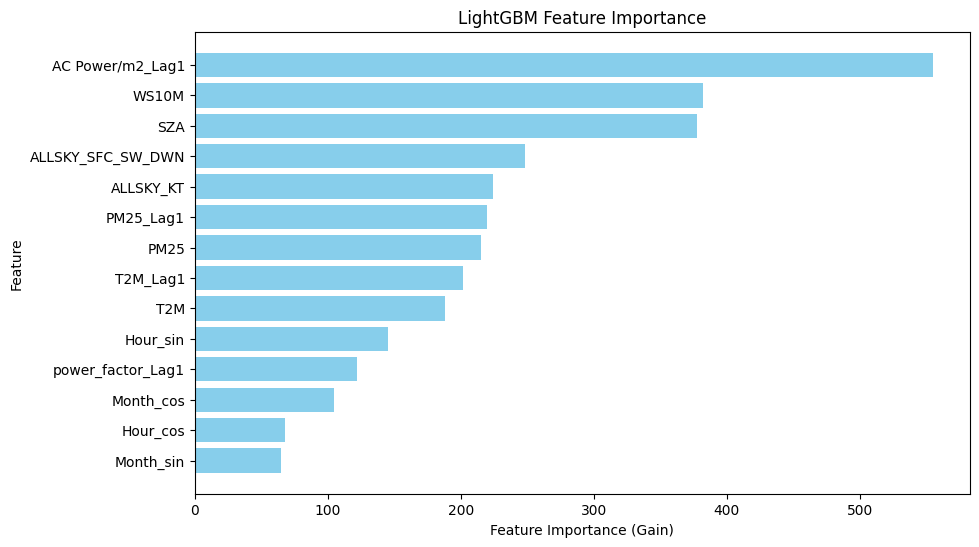

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor

# 1. Extract feature importance
importance = lgb_shallow.feature_importances_

# 2. Create a DataFrame
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importance
})

# 3. Sort features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# 4. Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel("Feature Importance (Gain)")
plt.ylabel("Feature")
plt.title("LightGBM Feature Importance")
plt.gca().invert_yaxis() # Highest importance at the top
plt.show()

In [ ]:
lgb_shallow.booster_.save_model('lgbm_shallow_model.json')

#### Polynomial Regression

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

# Instantiate PolynomialFeatures with degree 2 and no bias term
poly = PolynomialFeatures(degree=2, include_bias=False)

# Apply fit_transform to X_train
X_train_poly = poly.fit_transform(X_train)

# Apply transform to X_test using the same fitted object
X_test_poly = poly.transform(X_test)

print(f"Original X_train shape: {X_train.shape}")
print(f"Polynomial X_train shape: {X_train_poly.shape}")
print(f"Original X_test shape: {X_test.shape}")
print(f"Polynomial X_test shape: {X_test_poly.shape}")

Original X_train shape: (3592, 14)
Polynomial X_train shape: (3592, 119)
Original X_test shape: (898, 14)
Polynomial X_test shape: (898, 119)


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, r2_score

# Create a pipeline with StandardScaler and LinearRegression
poly_reg_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('linear_regression', LinearRegression())
])

# Train the pipeline on the polynomial features
poly_reg_pipeline.fit(X_train_poly, y_train)

# Make predictions on the training and test sets
y_train_pred_poly = poly_reg_pipeline.predict(X_train_poly)
y_test_pred_poly = poly_reg_pipeline.predict(X_test_poly)

# Evaluate the model
train_mae_poly = mean_absolute_error(y_train, y_train_pred_poly)
test_mae_poly = mean_absolute_error(y_test, y_test_pred_poly)

train_r2_poly = r2_score(y_train, y_train_pred_poly)
test_r2_poly = r2_score(y_test, y_test_pred_poly)

print("Polynomial Regression with Pipeline:")
print(f"Train MAE: {train_mae_poly:.4f} | Test MAE: {test_mae_poly:.4f}")
print(f"Train R2 : {train_r2_poly:.4f}  | Test R2 : {test_r2_poly:.4f}")

Polynomial Regression with Pipeline:
Train MAE: 4.4683 | Test MAE: 3.7278
Train R2 : 0.6173  | Test R2 : 0.5879


##### Generating some data with only pm2.5 varying to visualize it's effect on model predictions

In [ ]:
import pandas as pd
import numpy as np

# Define the constant, hardcoded baseline values (mean)
BASELINE_CONSTANTS = {
    'ALLSKY_SFC_SW_DWN': 544.354,
    'ALLSKY_KT': 0.547,
    'T2M': 21.903,
    'WS10M': 6.304,
    'SZA': 40.768,
    'T2M_Lag1': 21.889,
    'AC Power/m2_Lag1': 20.246,
    'power_factor_Lag1': 0.947,
    'Hour_sin': -0.119,
    'Hour_cos': -0.824,
    'Month_sin': -0.076,
    'Month_cos': -0.076,
    'PM25_Lag1': 8.172
}

# Define the range for PM25 (from 0 to 150)
pm25_range = np.linspace(start=0.0, stop=150.0, num=10)

# Create the sensitivity DataFrame
# 1. Initialize with the varying PM25 values
data = {
    'PM25': pm25_range
}
df_sensitivity = pd.DataFrame(data)

# 2. Add the constant features
for feature, value in BASELINE_CONSTANTS.items():
    df_sensitivity[feature] = value

# Define the final desired column order
ALL_FEATURES_ORDER = [
    'PM25', 'ALLSKY_SFC_SW_DWN', 'ALLSKY_KT', 'T2M', 'WS10M', 'SZA',
    'T2M_Lag1', 'PM25_Lag1', 'AC Power/m2_Lag1', 'power_factor_Lag1',
    'Hour_sin', 'Hour_cos', 'Month_sin', 'Month_cos'
]

# 3. Reorder the columns
df_sensitivity = df_sensitivity[ALL_FEATURES_ORDER]

# Print the resulting hardcoded DataFrame
print("Hardcoded PM25 Sensitivity Test Data:")
print(df_sensitivity)

Hardcoded PM25 Sensitivity Test Data:
         PM25  ALLSKY_SFC_SW_DWN  ALLSKY_KT     T2M  WS10M     SZA  T2M_Lag1  \
0    0.000000            544.354      0.547  21.903  6.304  40.768    21.889   
1   16.666667            544.354      0.547  21.903  6.304  40.768    21.889   
2   33.333333            544.354      0.547  21.903  6.304  40.768    21.889   
3   50.000000            544.354      0.547  21.903  6.304  40.768    21.889   
4   66.666667            544.354      0.547  21.903  6.304  40.768    21.889   
5   83.333333            544.354      0.547  21.903  6.304  40.768    21.889   
6  100.000000            544.354      0.547  21.903  6.304  40.768    21.889   
7  116.666667            544.354      0.547  21.903  6.304  40.768    21.889   
8  133.333333            544.354      0.547  21.903  6.304  40.768    21.889   
9  150.000000            544.354      0.547  21.903  6.304  40.768    21.889   

   PM25_Lag1  AC Power/m2_Lag1  power_factor_Lag1  Hour_sin  Hour_cos  \
0      8

### Pm2.5 against predictions using polynomial regressor. (Due to the absence of high pm2.5 data in training, the model predicts negative values as pm2.5 decreases output power)

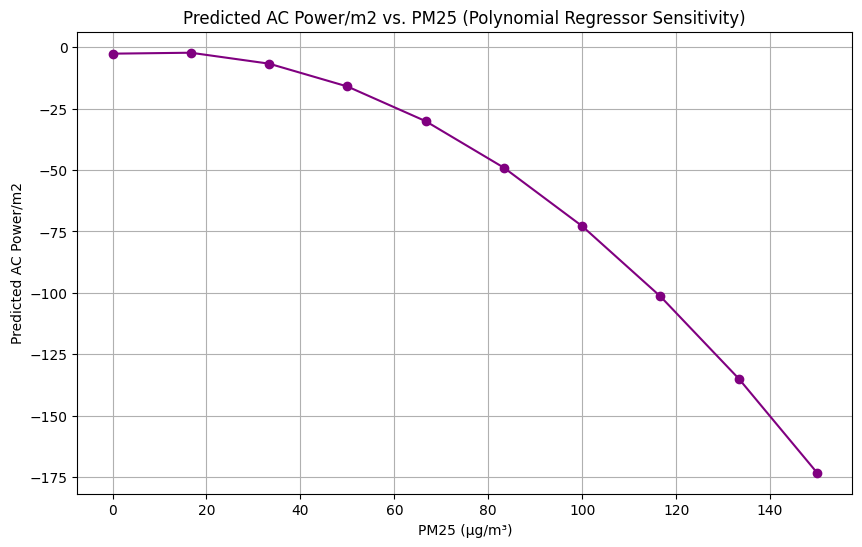

In [ ]:
import matplotlib.pyplot as plt

# Transform df_sensitivity to polynomial features using the same 'poly' object
df_sensitivity_poly = poly.transform(df_sensitivity)

# Make predictions using the polynomial regression pipeline
sensitivity_preds_poly = poly_reg_pipeline.predict(df_sensitivity_poly)

# Plot the predictions against the PM25 column
plt.figure(figsize=(10, 6))
plt.plot(df_sensitivity['PM25'], sensitivity_preds_poly, marker='o', linestyle='-', color='purple')
plt.xlabel('PM25 (μg/m³)')
plt.ylabel('Predicted AC Power/m2')
plt.title('Predicted AC Power/m2 vs. PM25 (Polynomial Regressor Sensitivity)')
plt.grid(True)
plt.show()

#### Log transforming the targest to avoid negative values

In [ ]:
import numpy as np

# Apply np.log1p to y_train
y_train_log = np.log1p(y_train)

# Apply np.log1p to y_test
y_test_log = np.log1p(y_test)

print("y_train_log head:")
print(y_train_log.head())
print("\ny_test_log head:")
print(y_test_log.head())

y_train_log head:
1    2.327925
2    2.822221
3    2.910810
4    2.626335
5    2.670174
Name: AC Power/m2, dtype: float64

y_test_log head:
4087    3.456568
4088    3.440248
4090    3.343831
4091    3.393795
4092    3.393795
Name: AC Power/m2, dtype: float64


#### Linear regression on the log tranformed data

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np

# Create a pipeline with StandardScaler and LinearRegression
log_reg_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('linear_regression', LinearRegression())
])

# Train the pipeline on the original features and log-transformed target
log_reg_pipeline.fit(X_train, y_train_log)

# Make predictions on the training and test sets (log-transformed predictions)
y_train_pred_log = log_reg_pipeline.predict(X_train)
y_test_pred_log = log_reg_pipeline.predict(X_test)

# Inverse transform the predictions back to the original scale
y_train_pred = np.expm1(y_train_pred_log)
y_test_pred = np.expm1(y_test_pred_log)

# Evaluate the model on the original scale
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("Linear Regression with Log-Transformed Target:")
print(f"Train MAE: {train_mae:.4f} | Test MAE: {test_mae:.4f}")
print(f"Train R2 : {train_r2:.4f}  | Test R2 : {test_r2:.4f}")

Linear Regression with Log-Transformed Target:
Train MAE: 5.3235 | Test MAE: 4.4386
Train R2 : 0.4770  | Test R2 : 0.4995


#### Visualizing the Hybrid model of lightGBM for PM2.5 < 30 and logarithmic linear regression for PM2.5 > 30

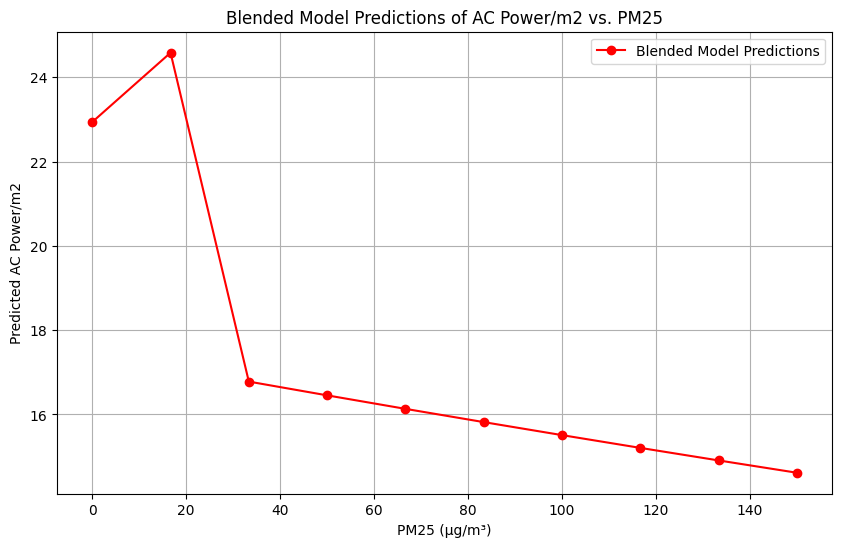

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Make predictions using lgb_shallow (for PM25 < 30)
preds_lgb_shallow = lgb_shallow.predict(df_sensitivity)

# 2. Make predictions using log_reg_pipeline (for PM25 >= 30)
# its output needs to be inverse transformed.
preds_reg_log_raw = log_reg_pipeline.predict(df_sensitivity)
preds_reg_log = np.expm1(preds_reg_log_raw)

# Create an empty array to store the blended predictions
blended_preds = np.zeros(len(df_sensitivity))

# Apply the conditional logic for blending
for i, pm25_val in enumerate(df_sensitivity['PM25']):
    if pm25_val < 30:
        blended_preds[i] = preds_lgb_shallow[i]
    else:
        blended_preds[i] = preds_reg_log[i]

# Plot the blended predictions against PM25
plt.figure(figsize=(10, 6))
plt.plot(df_sensitivity['PM25'], blended_preds, marker='o', linestyle='-', color='red', label='Blended Model Predictions')
plt.xlabel('PM25 (μg/m³)')
plt.ylabel('Predicted AC Power/m2')
plt.title('Blended Model Predictions of AC Power/m2 vs. PM25')
plt.legend()
plt.grid(True)
plt.show()

#### Saving this model

In [ ]:
import joblib

# Save the log_reg_pipeline
joblib.dump(log_reg_pipeline, 'log_reg_pipeline.joblib')
print("log_reg_pipeline saved successfully to 'log_reg_pipeline.joblib'")

log_reg_pipeline saved successfully to 'log_reg_pipeline.joblib'


### Hyperparameter Tuning for LightGBM Model using RandomSearchCV

In [ ]:
from scipy.stats import randint, uniform

# Define the parameter distribution for the LightGBM model
param_dist = {
    'n_estimators': randint(100, 1000),
    'learning_rate': uniform(0.01, 0.2),
    'num_leaves': randint(20, 60),
    'max_depth': randint(3, 15),
    'min_child_samples': randint(20, 100),
    'subsample': uniform(0.6, 0.4),  # uniform(loc, scale) where scale is (high - loc)
    'colsample_bytree': uniform(0.6, 0.4),
    'reg_alpha': uniform(0.0, 0.5),
    'reg_lambda': uniform(0.0, 0.5)
}

print("Hyperparameter distribution for LightGBM defined successfully.")

Hyperparameter distribution for LightGBM defined successfully.


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMRegressor

# Instantiate the LGBMRegressor model
lgbm_model = LGBMRegressor(random_state=42)

# Create a RandomizedSearchCV object
# We'll use 'neg_mean_absolute_error' as the scoring metric, as lower MAE is better
# n_iter specifies the number of parameter settings that are sampled
# cv specifies the number of folds for cross-validation
random_search = RandomizedSearchCV(
    estimator=lgbm_model,
    param_distributions=param_dist,
    n_iter=50, # Number of different parameter settings to sample
    scoring='neg_mean_absolute_error',
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1 # Use all available cores
)

# Fit the random search to the training data
random_search.fit(X_train, y_train)

print("Randomized Search Cross-Validation completed successfully.")
print(f"Best parameters found: {random_search.best_params_}")
print(f"Best MAE score (negative): {random_search.best_score_:.4f}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000912 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2194
[LightGBM] [Info] Number of data points in the train set: 3592, number of used features: 14
[LightGBM] [Info] Start training from score 21.873192
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

In [ ]:
from sklearn.metrics import mean_absolute_error, r2_score

# Get the best estimator from RandomizedSearchCV
tuned_lgbm = random_search.best_estimator_

# Make predictions on the training and test sets with the tuned model
train_pred_tuned = tuned_lgbm.predict(X_train)
test_pred_tuned = tuned_lgbm.predict(X_test)

# Evaluate the tuned model
train_mae_tuned = mean_absolute_error(y_train, train_pred_tuned)
test_mae_tuned = mean_absolute_error(y_test, test_pred_tuned)

train_r2_tuned = r2_score(y_train, train_pred_tuned)
test_r2_tuned = r2_score(y_test, test_pred_tuned)

print("Tuned LightGBM Model:")
print(f"Train MAE: {train_mae_tuned:.4f} | Test MAE: {test_mae_tuned:.4f}")
print(f"Train R2 : {train_r2_tuned:.4f}  | Test R2 : {test_r2_tuned:.4f}")

Tuned LightGBM Model:
Train MAE: 4.1423 | Test MAE: 3.5881
Train R2 : 0.6609  | Test R2 : 0.6005


In [ ]:
lgb_shallow.booster_.save_model('lgbm_shallow_model.json')